<a href="https://colab.research.google.com/github/snel-repo/ComputationThruDynamicsBenchmark/blob/main/examples/NeuroMatchNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1>
Project title
</h1>



__Content creators:__ Chris Versteeg

__Content reviewers:__ Chris Versteeg, Hannah Choi, Eva Dyer

__Content editors:__ Konstantinos Tsafatinos

__Production editors:__ Konstantinos Tsafatinos

__Our 2024 Sponsors:__ ?


# Characterizing computational similarity in task-trained recurrent neural networks

Researchers training artificial networks to perform tasks (e.g., image classification, motor control) have found that the activity in the artificial networks can resemble the activity of biological neurons from brain areas thought to perform similar tasks. Unfortunately, it is unclear whether a superficial similarity in neural activation necessarily translates to a conserved computational strategy. We need ways to assess how well different models are able to capture the computational principles, which will require datasets where the ground-truth computations are known and we can analyze similarity between artificial and natural systems. The aim of this project is to explore ways to measure alignment in dynamical systems, and to study different approaches to quantify the changes in representations across different tasks and across different architectures.

# Project Template

<img src="png/projtemplate.jpg" width="1200"/>

# Data Exploration Notebook

In [ ]:
# ! git clone https://github.com/snel-repo/ComputationThruDynamicsBenchmark.git
# %cd ComputationThruDynamicsBenchmark
# ! pip install -e .
# RUN THIS CELL, THEN RESTART SESSION AS PROMPTED (BUTTON AT BOTTOM OF THIS CELL'S FINISHED OUTPUT). DO NOT NEED TO RUN AGAIN
# !mkdir /content/ComputationThruDynamicsBenchmark/content
# !mkdir /content/ComputationThruDynamicsBenchmark/content/datasets
# !mkdir /content/ComputationThruDynamicsBenchmark/content/datasets/dt
# !mkdir /content/ComputationThruDynamicsBenchmark/content/datasets/sim
# !mkdir /content/ComputationThruDynamicsBenchmark/content/datasets/tt

In [1]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
random.seed(2024)
dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

/home/csverst/Github/CtDBenchmark/



## Step 1: Generating your datasets

The Computation-Thru-Dynamics Benchmark has three distinct behavioral tasks.

These tasks are called:
1. Three-Bit Flip-Flop (3BFF)
2. MultiTask
3. RandomTargetReach

We chose these tasks because they represent a spectrum of complexities and the state of our previous understanding of their underlying computation.
 
The actions that the model takes in the "coupled" task can affect the future inputs, making it an important test case for being able to understand the dynamics of interacting systems.

<img src="png/TaskComplexity-01.png" width="600"/>

Each task (which we call a "task environment") follows a standardized format that allows alternative task environments to be incorporated without any changes to the training pipeline.

Here we'll take a walk through the two tasks in the project template (TBFF and RandomTargetReach) and inspect the behavior of networks trained on these environments.

### Task 1: 3-Bit Flip-Flop (Q1 - Q4)

We're going to start out with the task that launched a thousand Nature papers, the 3-Bit Flip-Flop. [Sussillo & Barak 2013](https://pubmed.ncbi.nlm.nih.gov/23272922/) used the three-bit flip-flop their seminal attempts to understand how dynamics can give rise to computation! 

The code snippet below intantiates an "TaskEnv" object, which contains the logic for the NBFF task.

The default parameters are shown in ./interpretability/task_modeling/configs/env_task/NBFF.yaml, but try changing the parameters below to see how that affects trials generated from the environment. Note that this task is modular in the number of bits as well, so it provides an easy way to scale the dimensionality of a very simple dynamical system.

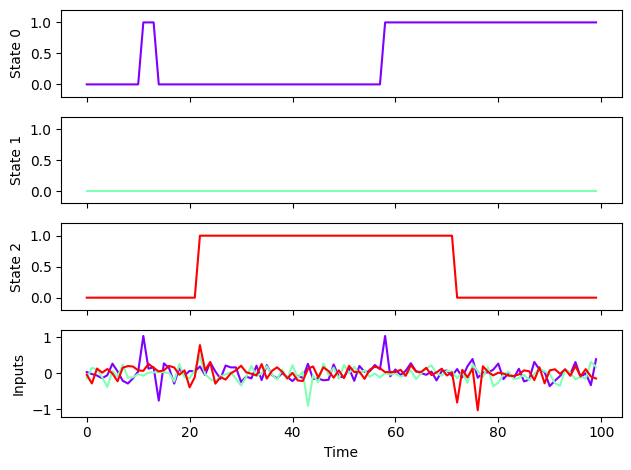

In [72]:
from ctd.task_modeling.task_env.task_env import NBitFlipFlop

n = 3
trial_length = 100
switch_prob = 0.015
noise = 0.15

env_3bff = NBitFlipFlop(
    n = n, 
    n_timesteps=trial_length, 
    switch_prob=switch_prob, 
    noise=noise
    )

env_3bff.render()

Above, we are plotting the inputs and outputs of the 3BFF task. One trial is 500 time steps, each with a 1% probability of getting an "up" or "down" pulse on each of its 3 input channels. When the task receives an "up" pulse, the state corresponding to that input channel moves from zero to one (if possible), and if a state at one receives a "down" pulse, it goes to zero. In this way, this system acts as 3 bits of memory, encoding 8 potential system states (2^3 states). We add noise to the inputs of the system so that it better reflects realistic computations that a neural circuit might perform.

Another way to visualize this is to view the three states in 3D. Below you can see that the 8 potential states appear as the vertices of a cube. Each trial is plotted as column. 

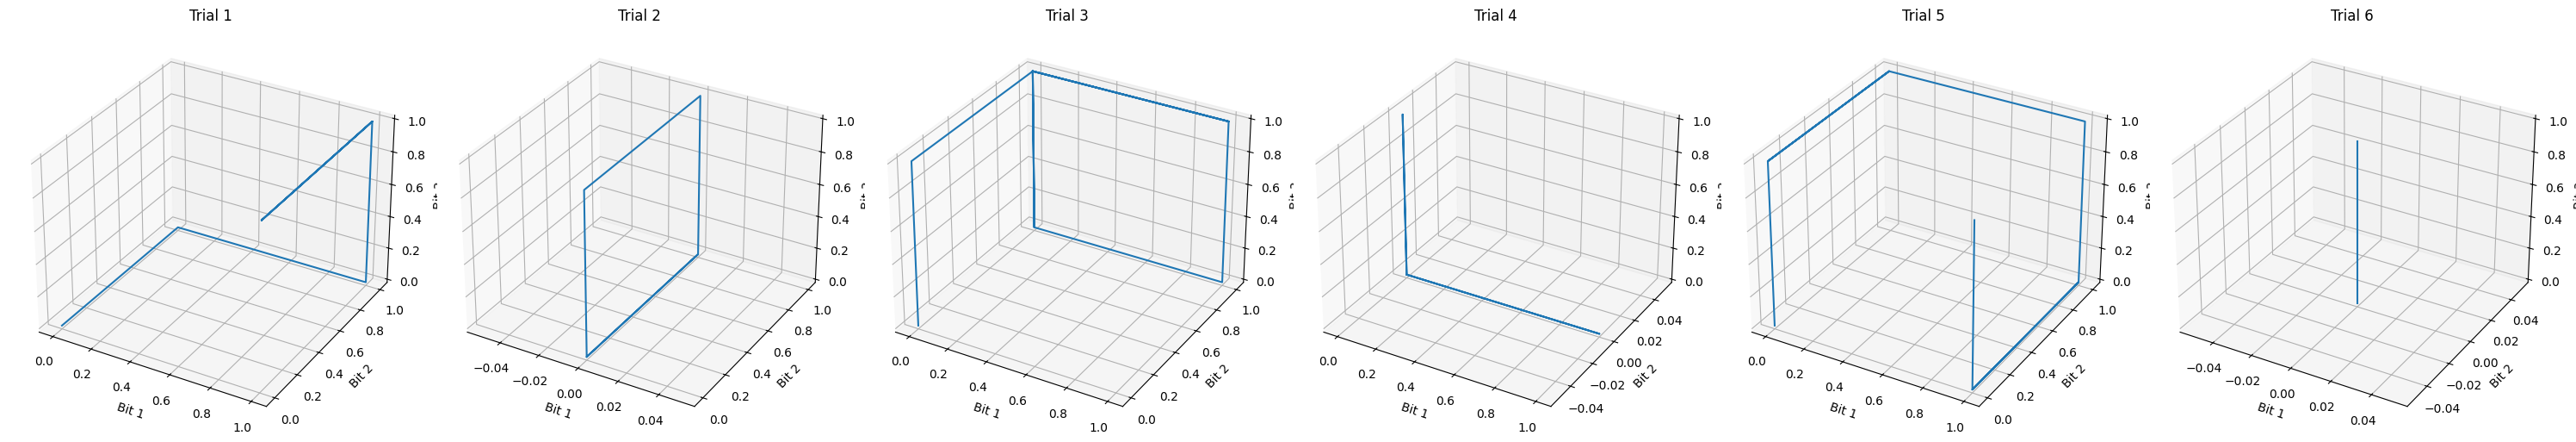

In [73]:
env_3bff.render_3d(n_trials=6)

Now that we can see the basic logic of the task, let's do a basic overview of what task-training is!

<img src="png/TTModelExample-01.png" width="600"/>

For task-training, we are simply training a model (e.g., an RNN) to produce a set of outputs given a set of inputs. This input/output relationship defines the task that the model is performing. In the case of 3BFF, an input pulse should cause the model's output to change in a way that reflects the switching of a bit.

### 3BFF Training Objective:
3BFF models are trained to minimize the MSE between the desired output and the output of the model, with the following qualification: The loss contributions of a given bit were zeroed in a short window after that bit received an input pulse. This reduces the stiffness of the learned dynamics and leads to simpler fixed-point structures. The specific implementation of the loss function can be found in ctd/task_modeling/task_env/loss_func.py.

For this tutorial, we are using PyTorch Lightning to train our models, which abstracts much of the complexity away.

In [74]:
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer

# Step 1: Instantiate the model
rnn = GRU_RNN(latent_size = 128) # Look in ctd/task_modeling/models for alternative choices!

# Step 2: Instantiate the task environment
task_env = env_3bff

# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)

# Step 4: Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Step 5: Initialize the model with the input and output sizes (3 inputs, 3 outputs, in this case)
rnn.init_model(
    input_size = task_env.observation_space.shape[0], 
    output_size = task_env.action_space.shape[0]
    )

# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Step 7: Define the PyTorch Lightning Trainer object
trainer = Trainer(max_epochs=500,enable_progress_bar=False)

# Step 8: Fit the model
trainer.fit(task_wrapper, task_datamodule)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name  | Type    | Params
----------------------------------
0 | model | GRU_RNN | 51.6 K
----------------------------------
51.6 K    Trainable params
0         Non-trainable params
51.6 K    Total params
0.206     Total estimated model params size (MB)
/home/csverst/miniconda3/envs/build5/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_ste

Now, we save the trained model and datamodule into a folder for use in future analyses using pickle!

In [14]:
import pickle
# save model as .pkl
save_dir = pathlib.Path(HOME_DIR) / "models_GRU_128"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

So that we can start comparing our models, we're going to train a second GRU_RNN to perform the 3BFF task, except this time, we'll increase the latent size to 128! 

Notice that we're using the same datamodule as for the first model, meaning that we can directly compare the two models trial-by-trial.

In [70]:
from ctd.task_modeling.model.node import NODE
rnn = NODE(latent_size = 3, num_layers = 3, layer_hidden_size=64) # Look in ctd/task_modeling/models for alternative choices!
task_wrapper = TaskTrainedWrapper(learning_rate=1e-2, weight_decay = 1e-8)
rnn.init_model(
    input_size = task_env.observation_space.shape[0], 
    output_size = task_env.action_space.shape[0]
    )
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)
trainer = Trainer(max_epochs=500)

trainer.fit(task_wrapper, task_datamodule)

save_dir = pathlib.Path(HOME_DIR) / "models_NODE_3"
save_dir.mkdir(exist_ok=True)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# save datamodule as .pkl
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/csverst/Github/CtDBenchmark/examples/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name  | Type | Params
-------------------------------
0 | model | NODE | 4.8 K 
-------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


To make your life easier, we've provided an "analysis" object that abstracts away much of the data handling, allowing you to work more easily with the data from the models.

The analysis object also offers visualization tools that can help to see how well the trained model learned to perform the task!

For example, plot_trial_io is a function that plots (for a specified number of trials):
- Latent activity
- Controlled output
- Target output
- Noisy inputs to model

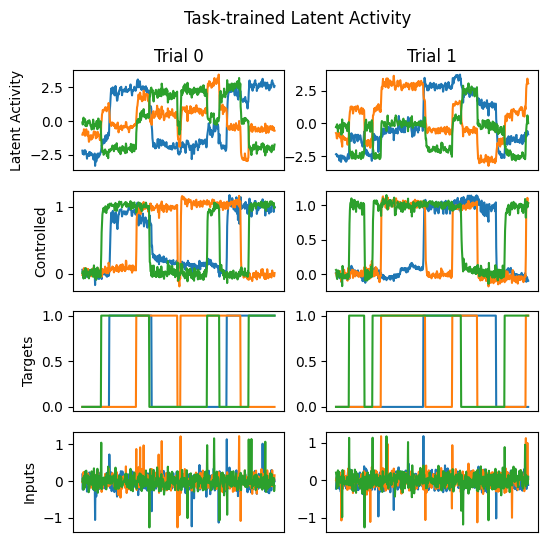

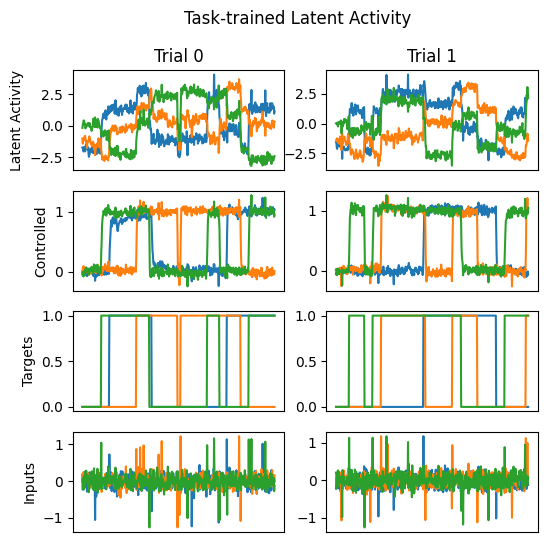

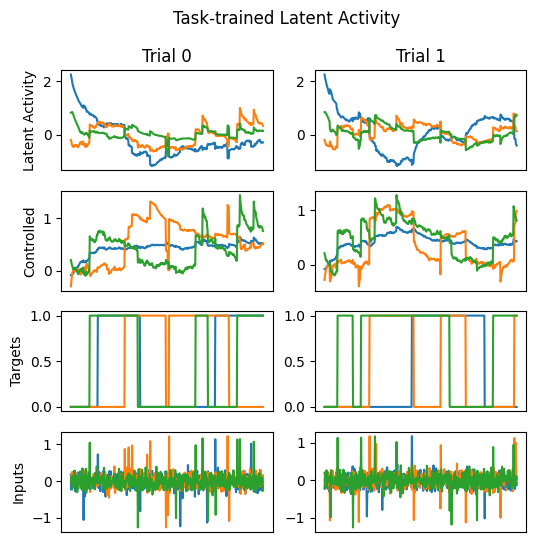

In [71]:
from ctd.comparison.analysis.tt.tt import Analysis_TT

fpath_GRU_128 = HOME_DIR + "models_GRU_128/"
# Create the analysis object:
analysis_GRU_128 = Analysis_TT(
    run_name = "GRU_128_3bff", 
    filepath = fpath_GRU_128)

fpath_NODE = HOME_DIR + "models_NODE_3/"
# Create the analysis object:
analysis_NODE = Analysis_TT(
    run_name = "NODE_3_3bff", 
    filepath = fpath_NODE)

analysis_GRU_128.plot_trial_io(num_trials = 2)
analysis_NODE.plot_trial_io(num_trials = 2)

There are also useful data visualization functions, such as visualizing a scree plot of the latent activity.

array([0.40320567, 0.2550536 , 0.22795434, 0.01913414, 0.01398877,
       0.01101618, 0.00781999, 0.00645055, 0.00609002, 0.00470713])

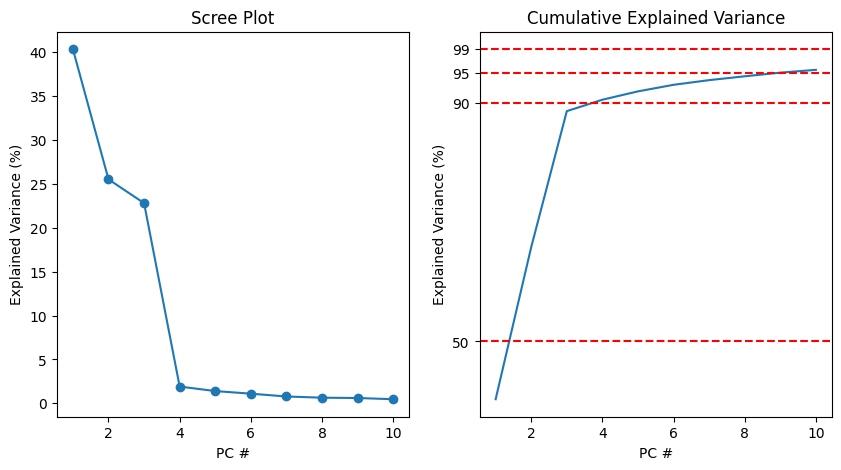

In [36]:
analysis_GRU_128.plot_scree()

Importantly, the analysis object also provides functions that give access to the raw latent activity, predicted outputs, etc. of the trained models! All of these functions accept a "phase" variable that designates whether to return the training and/or validation datasets. 
These functions are:
- get_latents(): Returns latent activity of the trained model
- get_inputs(): Returns the inputs to the model (for 3BFF, the input pulses)
- get_model_output(): Returns a dict that contains all model outputs:
  - controlled - the variable that the model is controlling
  - latents - the latent activity
  - actions - the output from the model (for RandomTarget only)
  - states - the state of the environment (for RandomTarget only)
  - joints - Joint angles (for RandomTarget only)

In [37]:
print(f"All data shape: {analysis_GRU_128.get_latents().shape}")
print(f"Train data shape: {analysis_GRU_128.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_GRU_128.get_latents(phase = 'val').shape}")

All data shape: torch.Size([1000, 500, 64])
Train data shape: torch.Size([800, 500, 64])
Validation data shape: torch.Size([200, 500, 64])


## Question 2: Using affine transformations to compare latent activity

Now that we have the latent activity for the 64D and the 128D GRU models trained on 3BFf, we can investigate how similar their latent activity is.

To do this, we're going to be fitting linear regression models from one set of latents to the other and quantifying the model peformance with the R2! 

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_GRU_128
target = analysis_NODE

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

print(f"Latent shape for source model: {latents_source.shape}"
      f"\nLatent shape for target model: {latents_targ.shape}")




Latent shape for source model: (800, 500, 64)
Latent shape for target model: (800, 500, 128)
R2 of linear regression fit: [0.96836908 0.94421365 0.96106606 0.93949958 0.93477653 0.94141536
 0.72010515 0.74641692 0.80161213 0.80910586 0.79433412 0.73078042
 0.76050441 0.73565616 0.70985314 0.52007769 0.69388206 0.62073324
 0.50919189 0.63990599 0.53640254 0.60619685 0.44846976 0.50133347
 0.4578878  0.44116351 0.45797839 0.49509897 0.49696926 0.45758083
 0.41935779 0.39074061 0.35060845 0.40853319 0.42812018 0.40586178
 0.33041832 0.33254756 0.36506836 0.38451729 0.39098664 0.37673386
 0.33177427 0.21529401 0.34301676 0.16951545 0.27768245 0.21564211
 0.27511641 0.21237776 0.15873694 0.20730052 0.22911504 0.17077465
 0.14894391 0.1740112  0.19432316 0.13313009 0.12918267 0.12270655
 0.1452585  0.13528993 0.15564176 0.17529915 0.11662935 0.13425721
 0.08143904 0.11384589 0.18913984 0.16769597 0.13011767 0.14356127
 0.12272383 0.11007569 0.09879059 0.09412413 0.14006658 0.13711336
 0.1368

In [ ]:

# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

So the variance weighted R2 from the source to the target is ~0.93. Try reversing the direction (the source and targets) and see how well the model fits!

One final tool that is provided to you is the comparison object, which does many of these direct comparisons within the object itself. Here is one example visualization that shows how similar the latent activity of two example trials are for these two models!

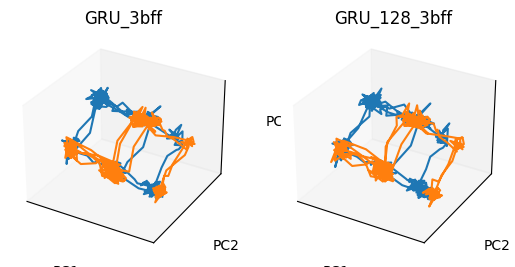

In [63]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=2)

## Question 3: Fixed-point finding
Finally, we can use fixed-point finding to inspect the linearized dynamics of the trained model.
Fixed points are points in the dynamics for which the flow field is zero, meaning that points at that location do not move.

We use a modified version of a fixed point finder released by [Golub et al. 2018](https://github.com/mattgolub/fixed-point-finder) to search the flow field for these zero points.

Try changing some of these parameters: 
- How quickly are the fixed-points found in the model?
- How many initializations are needed to find the fixed points?
- Do the stability properties tell us anything about the underlying computation?

Importantly from [Driscol et al. 2022](https://www.biorxiv.org/content/10.1101/2022.08.15.503870v1.full.pdf), we know that changes in the inputs can have large effects on the fixed point architecture, so we're going to set the inputs to zero in this optimization.


Iteration 500/20000
q = 7.74E-03 +/- 3.17E-02
dq = 3.96E-05 +/- 1.63E-04

Iteration 1000/20000
q = 1.36E-03 +/- 5.47E-03
dq = 3.17E-06 +/- 1.38E-05

Iteration 1500/20000
q = 5.59E-04 +/- 2.16E-03
dq = 7.67E-07 +/- 3.10E-06

Iteration 2000/20000
q = 3.15E-04 +/- 1.22E-03
dq = 3.10E-07 +/- 1.20E-06

Iteration 2500/20000
q = 2.03E-04 +/- 7.85E-04
dq = 1.63E-07 +/- 6.38E-07

Iteration 3000/20000
q = 1.39E-04 +/- 5.38E-04
dq = 9.83E-08 +/- 3.90E-07

Iteration 3500/20000
q = 9.95E-05 +/- 3.81E-04
dq = 6.45E-08 +/- 2.57E-07

Iteration 4000/20000
q = 7.27E-05 +/- 2.75E-04
dq = 4.44E-08 +/- 1.77E-07

Iteration 4500/20000
q = 5.40E-05 +/- 2.01E-04
dq = 3.15E-08 +/- 1.25E-07

Iteration 5000/20000
q = 4.05E-05 +/- 1.48E-04
dq = 2.29E-08 +/- 9.03E-08

Iteration 5500/20000
q = 3.06E-05 +/- 1.10E-04
dq = 1.69E-08 +/- 6.56E-08

Iteration 6000/20000
q = 2.33E-05 +/- 8.23E-05
dq = 1.26E-08 +/- 4.80E-08

Iteration 6500/20000
q = 1.79E-05 +/- 6.22E-05
dq = 9.43E-09 +/- 3.48E-08

Iteration 7000/20000
q = 

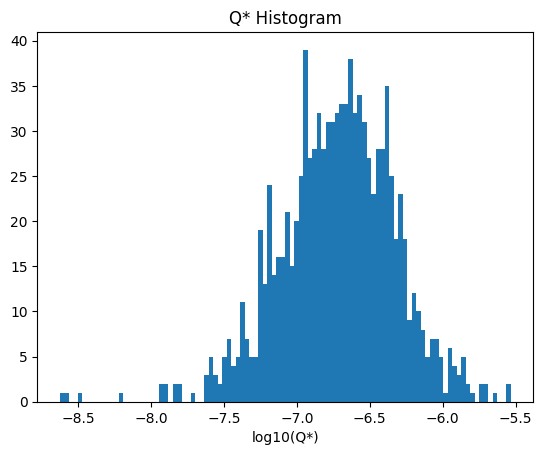

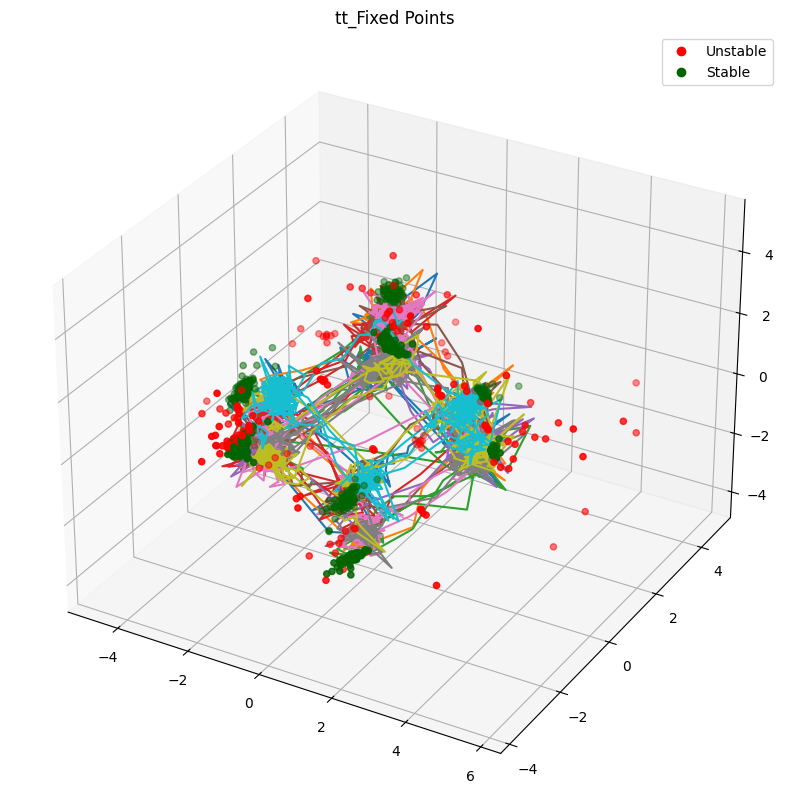

In [64]:
import torch
fps = analysis_GRU_128.plot_fps(
inputs= torch.zeros(3),
n_inits=1024,
learning_rate=1e-3,
noise_scale=0.0,
max_iters=20000,
seed=0,
compute_jacobians=True,
q_thresh=1e-5,
)

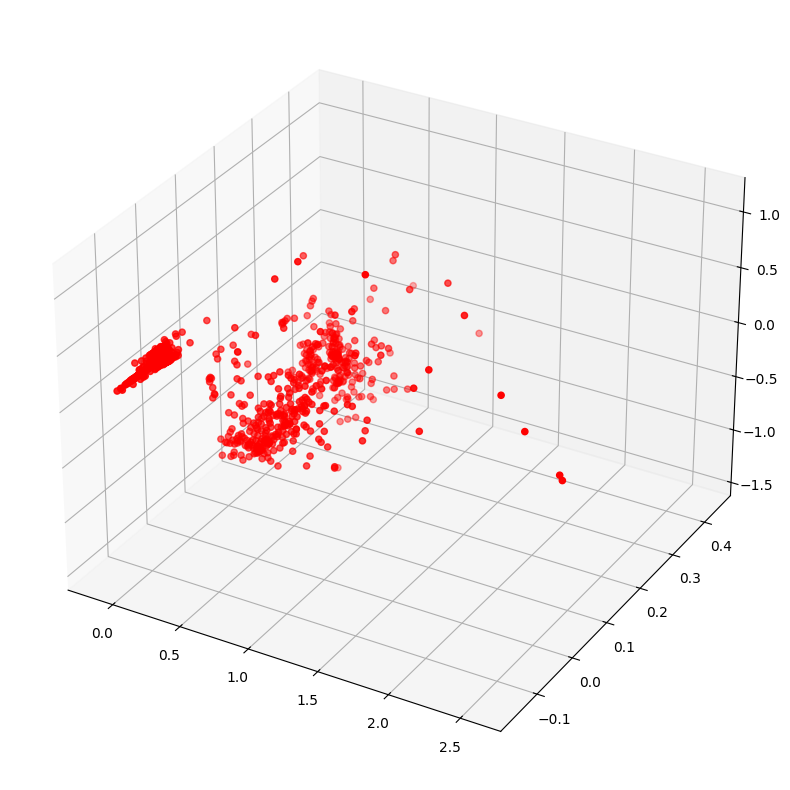

In [66]:
import matplotlib.pyplot as plt
q_thesh = 1e-6
q_vals = fps.qstar
x_star = fps.xstar[q_vals < q_thesh]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_star[:, 0], x_star[:, 1], x_star[:, 2], c='r', marker='o')

What can you find out about the FPs of the trained models? Can you modify the FP finding hps to get more interpretable results?

What can we learn about the computational solution built in this TBFF network from these fixed-point architectures?

## Task 2: Random Target:
The second task is a random-target reaching task performed by an RNN controlling a 2-joint musculoskeletal model of an arm actuated by 6 Mujoco muscles. This environment was built using MotorNet, a package developed by [Oli Codol et al.](https://github.com/OlivierCodol/MotorNet) that provides environments for training RNNs to control biomechanical models!

Here is a short clip of what this task looks like:

<img src="png/FinalGif.gif" width="300"/>


Behaviorally, the task has the following structure:
1. A random initial hand position is sampled from a range of reachable locations; the model is instructed to maintain that hand position.
2. A random target position is chosen from the range of reachable locations and fed to the model.
3. After a random delay period, a go-cue is fed to the model, which prompts the model to generate muscle activations that drive the hand to the target location.
4. On 20% of trials, the go-cue is never supplied ("catch" trials)
5. On 50% of trials, a randomly directed bump perturbation (5-10 N, 150-300 ms duration) is applied to the hand.
    - 50% of these bumps occur in a small window after the go-cue
    - 50% of these bumps occur at a random time in the trial

The model is trained to:
1. Minimize the MSE between the hand position and the desired hand position
2. Minimize the squared muscle activation

with each loss term being weighted by a scalar.


Let's load in the RNN trained to perform this task and take a look at its behavior.


In [19]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTargetDelay import TT_RandomTargetDelay
# Create the analysis object:

fpath_RT = HOME_DIR + "pretrained/20240327_RandomTarget_GRU_Final/max_epochs=1500 seed=0/"
analysis_tt_RT = TT_RandomTargetDelay(
    run_name = "tt_RandomTarget_pretrained", 
    filepath = fpath_RT)

FileNotFoundError: [Errno 2] No such file or directory: '/home/csverst/Github/CtDBenchmark/pretrained/20240327_RandomTarget_GRU_Final/max_epochs=1500 seed=0/model.pkl'

In [18]:
for x in range(16,19):
    analysis_tt_RT.plot_trial(trial_num = x)

NameError: name 'analysis_tt_RT' is not defined

Importantly, this task is distinct from the previous two tasks because the outputs of the model affect the subsequent inputs!

<img src="png/MotorNet Illustration-01.png" width="800"/>


Visualizing the latent dynamics of models trained on MotorNet tasks, we can see that there are complex features in the state space, but we'll leave that to you to figure out what they mean!

<img src="png/MotorNetGif.gif" width="300"/>



In summary, our three task environments were chosen to provide a feature-rich assortment of behaviors that can be used to test the accuracy of dynamical recovery of your data-trained models!

# Step 2: Neural Data Simulation
<img src="png/Step2-01.png" width="800"/>



Now that we have our RNN that is trained to perform three-bit flip-flop, we need to simulate the neural spiking activity.
For that, we are going to use the next object, called the Neural Data Simulator.



The neural data simulator is very simple; it takes in a datamodule and a trained model, and saves an .h5 file of neural firing rates to a location in your local directory where the data-trained models will be able to find it.

The process of simulating neural data has two steps:
1. Instantiate NeuralDataSimulator object with simulation parameters.
2. Pass the trained TT model, the datamodule that you want to simulate neural activity from, and some file paths to the simulate_neural_data method.

In the full code, the simulator is saved with the task-trained model so more neural activity can be simulated later if needed. Importantly, the datamodule used for simulation doesn't need to be the same datamodule used to train the model; this means allow for easy testing of generalizability of task-trained models.

Below is a schematic of the data simulation pipeline. See neural_simulator.py for information on the parameters and options for simulation.

<img src="png/SimulationDiagram.png" width="800"/>


In [ ]:
from ctd.task_modeling.simulator.neural_simulator import NeuralDataSimulator
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_env.task_env import NBitFlipFlop

# Create the task environment:
env_3bff = NBitFlipFlop(
    n = 3, 
    n_timesteps=500, 
    switch_prob=0.01, 
    noise=0.15
    )

# Create the task datamodule and generate the data:
dm_sim = TaskDataModule(env_3bff, n_samples = 1000, batch_size = 1000, seed= 4096)
dm_sim.prepare_data()
dm_sim.setup()

# Set the path to save the dataset:
dataset_path = pathlib.Path(HOME_DIR, "content", "datasets", "dt")
    
# Create the neural data simulator:
simulator = NeuralDataSimulator(
    n_neurons = 50,
    nonlin_embed=False, # IN DEVELOPMENT!
    # obs_noise = "poisson", # IN DEVELOPMENT!
)
    
wrapper = analysis_tt_3bff.wrapper
simulator.simulate_neural_data(
    task_trained_model=wrapper,
    datamodule= dm_sim,
    run_tag = "tt_3BFF_pretrained",
    subfolder="seed=4096",
    dataset_path= dataset_path,
    seed= 4096,
)

And that's it! 

We can change the number of neurons or the noise model if we want to test how violations of our assumptions can affect of inferred latent activity.

# Step 3: Data training

![Data-training](png/Step3-01.png)

Now that we have simulated "spiking" data, we can pretend that we recorded it from a brain!

One common way to estimate dynamics from neural recordings is to use a model called a Sequential Auto-Encoder (SAE).

![Data-training](png/SAE.png)

SAEs receive time-series data, and are trained with the objective of being able to reconstruct the inputs to the model as the product of a dynamical system (often with a dimensionality bottleneck).

--------------------------------------------------------------------------------------------------------------------------------------

Let's walk through how to train a model to reconstruct the simulated neural activity using the CtD Benchmark!

The models that are currently available to train on the benchmark datasets are:
- Standard SAEs (GRUs, Neural ODE, Vanilla RNNs)
- Latent Factor Analysis via Dynamical Systems (LFADS)

We are currently in the process of adding the capability for a suite of Linear Dynamical Systems models (LDS) using JAX (with help from the amazing David Zoltowski!).
- Jacobian Switching LDS
- Recurrent LDS


## The elephant in the room: Inputs?

As we have seen, inputs are an extremely important piece of the puzzle when it comes to understanding the dynamics of a system. So how will we deal with inputs for the CtD Benchmark?

We plan for our benchmark to support either supplying inputs to the model or allowing the model to use input inference when it is available (e.g., LFADS). 

For simplicity, the below models are trained with supplied ground-truth inputs.



-----------------------------------------------------------------------------------

We have provided pre-trained GRU-SAE and LFADS model trained on the 3Bit Flip-Flop task above. To train your own models, you can run the script run_data_training.py in examples/ folder!

Let's start by loading our model into a Analysis object and running fixed-point analysis on it to see what the structure looks like!

In [ ]:
from ctd.comparison.analysis.dt.dt import Analysis_DT
import dotenv
import os
import torch


dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
fpath_3bff_GRU_2_DT = ( HOME_DIR + "/pretrained_2/dt/20240301_NBFF_GRU_DT/")

analysis_dt_GRU_3bff_2 = Analysis_DT(
    run_name = "GRU_3B_1_DT",
    filepath = fpath_3bff_GRU_2_DT,)

analysis_dt_GRU_3bff_2.plot_fps(inputs = torch.zeros(3), device = "cpu") # change to CPU if available for speed

[Not great, not terrible.](https://giphy.com/clips/hamlet-chernobyl-not-great-terrible-33NFrPnlaN7lqUTM3V)

Now let's load an LFADS model trained on the same dataset to see if LFADS can get more accurate latent dynamics than the GRU.

Unfortunately, Colab doesn't have the RAM to load LFADS, so I'm also including the plots here for reference

In [ ]:
# import torch
# from interpretability.comparison.analysis.dt.dt import Analysis_DT
# fpath_3bff_LFADS_2_DT =( HOME_DIR + "pretrained_2/dt/20240302_NBFF_LFADS_DT/")

# analysis_dt_LFADS_3bff_2 = Analysis_DT(
#     run_name = "LFADS_3B_1_DT",
#     filepath = fpath_3bff_LFADS_2_DT,
#     model_type = "LFADS"
#     )

# analysis_dt_LFADS_3bff_2.plot_trial(num_trials=10)

# analysis_dt_LFADS_3bff_2.plot_fps( # For those with more RAM than Colab!
#     inputs = torch.zeros(3),
#     n_inits=512,
# )


Colab unfortunately doesn't have enough RAM to run the full heavy duty model for Fixed-Point finding, but I'm putting the resulting plot here for your reference; feel free to run this on a more powerful machine if you want to mess around with the parameters!

<img src="png/lfads_fps.png" width="800"/>

Qualitatively, LFADS looks like it's doing great at recovering the fixed points!

Now that we have walked through the data-training process, let's see some of the metrics that we are using to quantify the performance on latent recovery!

# Step 4: Comparing task-trained and data-trained networks

<img src="png/Step4-01.png" width="800"/>


Now that we've walked through the pipeline, let's get down to what we came here to do! 

**How can we compare the performance of our models in a quantitative way?**

I'm going to give toy examples to demonstrate the three metrics that we have implemented for quantitatively comparing our dynamics models:
1. Rate $R^2$
2. State $R^2$
2. Dynamical Similarity Analysis

To do this, let's use the NBFF task described above!

## Metric 1: Rate $R^2$


The first metric that is important to know is: Does our model actually fit the data well?

For that, we turn to Rate $R^2$. Rate $R^2$ is simply the goodness of fit between the inferred firing rates and the ground-truth activity of the task-trained network.

Let's load up a couple of networks and see how well they fit the data.

In [ ]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT
from interpretability.comparison.analysis.dt.dt import Analysis_DT
fpath_3bff_GRU_2 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=2/"
analysis_tt_GRU_3bff_2 = Analysis_TT(
    run_name = "GRU_3B_2", 
    filepath = fpath_3bff_GRU_2,
)

fpath_3bff_GRU_2_DT = (HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=2/20240301_NBFF_GRU_DT/")
analysis_dt_GRU_3bff_2 = Analysis_DT(
    run_name = "GRU_3B_1_DT",
    filepath = fpath_3bff_GRU_2_DT,
    )

fpath_3bff_Vanilla_2_DT = (HOME_DIR + "pretrained_2/dt/20240303_NBFF_VanillaRNN_DT/")
analysis_dt_Vanilla_3bff_2 = Analysis_DT(
    run_name = "Vanilla_3B_1_DT",
    filepath = fpath_3bff_Vanilla_2_DT,
    )

    

We have loaded three models into our Comparison object. The comparison object has built-in methods for quantified comparisons between models that have been loaded into it.

The three models in this Comparison are:
1. A Task-Trained GRU performing 3-bit Flip Flop
2. A Data-Trained GRU that was trained using data from (1).
3. A Data-Trained Vanilla RNN that was trained using data from (1).

Now we're going to test which model reconstructs the rates best!

In [ ]:
from interpretability.comparison.comparison import Comparison
comparison_R2 = Comparison()
comparison_R2.load_analysis(analysis_tt_GRU_3bff_2, reference_analysis=True)
comparison_R2.load_analysis(analysis_dt_GRU_3bff_2)
comparison_R2.load_analysis(analysis_dt_Vanilla_3bff_2)

When we compute Rate $R^2$, we get an $R^2$ value for every simulated neuron. For simplicity, we summarize the reconstruction performance of each model by taking the mean value across neurons.

In [ ]:
comparison_R2.compare_rate_r2()

Unsurprisingly, the GRU model is better able to reconstruct the firing rates of the task-trained model than the Vanilla RNN.

However: recent work from the Pandarinath lab has shown that models have an incentive to "invent" latent features if those features are helpful in reconstructing the neural activity. Therefore, optimizing for reconstruction performance can actually impose a perverse incentive for *less accurate* neural dynamics!

## Metric 2: State $R^2$

To address this concern, we introduce our second metric, called State $R^2$. State $R^2$ measures the extent to which the model reflects *only* the latent activity that is actually in the ground-truth system.

<img src="png/StateR2-01.png" width="600"/>

To provide some intuition for this metric, we're going to consider a very simple case. There are two shapes in the figure above, a ring and a wave. If the true underlying dynamics resemble the ring but our model-inferred dynamics resemble the wave, our model would be able to predict the flat ring on the right with high accuracy, but the flat ring cannot predict the wave.


In [ ]:

comparison_R2.plot_trials(num_trials=2)
comparison_R2.plot_trials_3d(num_trials=10)


If the datasets that we are interested in comparing have a 1:1 mapping between samples (i.e., they were seeing the same trials), then we can also provide one of the models as a "reference analysis", which will tell the plotting functions to linearly align the latent activity in the optimal way to predict the reference dataset. The first plot (without alignment) could potentially make it seem as though there are differences in the latent activity between the task-trained and data-trained models. The goodness-of-fit of this optimal affine transformation is defined as the State $R^2$.

In [ ]:
comparison_R2.plot_trials_reference(num_trials=2)
comparison_R2.plot_trials_3d_reference(num_trials=10)

Importantly, goodness-of-fit is calculated for each dimension independently and averaged, so dimensionality affects the estimated State $R^2$.

Try changing the num_pcs and see how this metric is affected!

In [ ]:
comparison_R2.compare_state_r2(num_pcs=3)

Looks like our GRU network is strictly better than our Vanilla RNN! Both the state and rate $R^2$ are higher, meaning that the GRU can reconstruct the neural activity better and doesn't seem to have invented latent features to do so!

## Metric 3: Dynamical Similarity Analysis:

Let's look at another toy problem of differentiating different computations being performed by RNNs. For this problem, I've chosen to train GRU models to perform 3, 4, and 5 bit versions of our N-bit Flip-Flop task. This presents an interesting challenge for methods of distinguishing dynamical systems, because the dynamics of 4 and 5 bit flip flop models actually contain within them (more than one!) three bit flip flop task!

Mitchell Ostrow is here to give a tutorial of his method, Dynamical Similarity Analysis!

---------------------------------------------------------------------------------

Now to see how it performs in action! 


The code below loads a few pre-trained models into analysis objects:
Specifically, I've provided two randomly initializations of training data and weights for GRU models trained to perform 3BFF, 4BFF, and 5BFF.

I've also supplied a Data-Trained model trained on the simulated spiking activity from one of the models in the task so that we can see if the task-trained network resembles the data-trained network in this test case.

In [ ]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT
from interpretability.comparison.analysis.dt.dt import Analysis_DT

fpath_3bff_GRU_1 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=0/"
analysis_tt_GRU_3bff_1 = Analysis_TT(
    run_name = "GRU_3B_1", 
    filepath = fpath_3bff_GRU_1,)

fpath_3bff_GRU_1_dt = HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=2/20240301_NBFF_GRU_DT/"
analysis_dt_GRU_3bff_1 = Analysis_DT(
    run_name = "GRU_3B_1_DT", 
    filepath = fpath_3bff_GRU_1_dt,)

fpath_3bff_GRU_2 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=2/"
analysis_tt_GRU_3bff_2 = Analysis_TT(
    run_name = "GRU_3B_2", 
    filepath = fpath_3bff_GRU_2,)

fpath_4bff_GRU_1 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_4BFF_GRU_Tutorial/n=4 weight_decay=1e-08 max_epochs=1500 seed=0/"
analysis_tt_GRU_4bff_1 = Analysis_TT(
    run_name = "GRU_4B_1", 
    filepath = fpath_4bff_GRU_1,)

fpath_4bff_GRU_2 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_4BFF_GRU_Tutorial/n=4 weight_decay=1e-08 max_epochs=1500 seed=2/"
analysis_tt_GRU_4bff_2 = Analysis_TT(
    run_name = "GRU_4B_2", 
    filepath = fpath_4bff_GRU_2,)   

fpath_5bff_GRU_1 = HOME_DIR + "pretrained_2/tt/NBFF/20240301_5BFF_GRU_Tutorial/n=5 weight_decay=1e-08 max_epochs=1500 seed=0/"
analysis_tt_GRU_5bff_1 = Analysis_TT(
    run_name = "GRU_5B_1",
    filepath = fpath_5bff_GRU_1,)

fpath_5bff_GRU_2 = HOME_DIR + "pretrained_2/tt/NBFF/20240301_5BFF_GRU_Tutorial/n=5 weight_decay=1e-08 max_epochs=1500 seed=2/"
analysis_tt_GRU_5bff_2 = Analysis_TT(
    run_name = "GRU_5B_2",
    filepath = fpath_5bff_GRU_2,)



In [ ]:
from interpretability.comparison.comparison import Comparison
comparison_DSA = Comparison()
comparison_DSA.load_analysis(analysis_tt_GRU_3bff_1)
comparison_DSA.load_analysis(analysis_dt_GRU_3bff_1)
comparison_DSA.load_analysis(analysis_tt_GRU_3bff_2)
comparison_DSA.load_analysis(analysis_tt_GRU_4bff_1)
comparison_DSA.load_analysis(analysis_tt_GRU_4bff_2)
comparison_DSA.load_analysis(analysis_tt_GRU_5bff_1)
comparison_DSA.load_analysis(analysis_tt_GRU_5bff_2)

comparison_DSA.plot_trials(num_trials=2)


In [ ]:
comparison_DSA.compare_dynamics_DSA(n_delays=50, rank = 200, percent_data=0.1, device = "cuda" ) # Set to "cpu" on Colab!

We can see that not only does DSA say that the GRU network trained on the simulated 3BFF data resembles the true underlying 3BFF data, we can also see that there is an orderly gradient of similarities as the systems become more complicated!

DSA seems to be able to capture similar dynamical systems, even when we don't have a point-to-point matching between systems!

# Conclusion + Next Steps:

Hope everyone found the tutorial informative (and that the Colab notebook worked :D ) ! We hope that you download the Benchmark codebase and put it to good use validating and comparing your data-trained models!

We plan to continue developing the CtD Benchmark to make it more useful to researchers, so if you are interested in adding features, reach out and let me know!

In particular:
- Better documentation + streamlined interface 
- New Metrics: CCA + variants
- New models: Fuller range of Linear Dynamical Systems models!
- New Task Environments: 
- A "Challenge" dataset for which we provide simulated neural activity without a ground truth, and challenge researchers to tell us what is happening!


# Thanks!

This couldn't possibly have come together without a whole host of help from a lot of people!

My mentor/co-organizer Chethan Pandarinath

The speakers:
- Srdjan Ostojic
- Chethan Pandarinath
- Tatiana Engel
- David Sussillo
- Kanaka Rajan
- Mitchell Ostrow

The CtD Benchmark Advisory Team:
- Chethan Pandarinath
- David Sussillo
- Srdjan Ostojic
- Scott Linderman

For help building features into the Benchmark:
- Laura Driscoll
- Oli Codol
- Jonathan Michaels
- David Zoltowski
- Sophie Liebkind
- Felix Pei
- Jonathan McCart

For help developing the tutorial notebook:
- Clay Washington
- Domenick Mifsud


Hope everyone has a safe trip home, and I'll see you next year!

